![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Applied_Generative_AI/Pipelines_LLM.ipynb)

# LLMs in Spark NLP

## **🎬 Colab Setup**

In [1]:
from google.colab import files

print("Please Upload your John Snow Labs License using the button below")
license_keys = files.upload()

Please Upload your John Snow Labs License using the button below


Saving spark_nlp_for_healthcare_spark_ocr_8734.json to spark_nlp_for_healthcare_spark_ocr_8734.json


In [4]:
from getpass import getpass


OPENAI_API_KEY = getpass("Please enter your open_api_key:")
# If you do not have an OpenAI key, you can skip the OpenAI section below and continue using open-source LLMs.

Please enter your open_api_key:··········


In [2]:
%pip install -q johnsnowlabs==5.4.1rc1 langchain langchain-community openai tiktoken faiss-cpu ctransformers
# !pip install -Uq nlu==5.4.1rc1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.6/983.6 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.5/328.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 579.2/579.2 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 83.7 MB

In [3]:
from johnsnowlabs import nlp


nlp.install()

👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_8734.json
📋 Stored John Snow Labs License in /root/.johnsnowlabs/licenses/license_number_0_for_Spark-Healthcare_Spark-OCR.json
👷 Setting up  John Snow Labs home in /root/.johnsnowlabs, this might take a few minutes.
🙆 JSL Home setup in /root/.johnsnowlabs
👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_8734.json
Installing /root/.johnsnowlabs/py_installs/spark_nlp_jsl-5.4.0-py3-none-any.whl to /usr/bin/python3
Installed 1 products:
💊 Spark-Healthcare==5.4.0 installed! ✅ Heal the planet with NLP! 


In [5]:
from johnsnowlabs import nlp, medical
import pyspark.sql.functions as F

import pandas as pd

import warnings

warnings.filterwarnings("ignore")

params = {
    "spark.driver.memory": "16G",
    "spark.kryoserializer.buffer.max": "2000M",
    "spark.driver.maxResultSize": "2000M",
    "spark.jsl.settings.openai.api.key": OPENAI_API_KEY,  # If you don't have the key, comment this line
}


hardware = "gpu"
spark = nlp.start(spark_conf=params, hardware_target=hardware)

👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_8734.json
🤓 Looks like you are missing some jars, trying fetching them ...
👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_8734.json
🙆 JSL Home setup in /root/.johnsnowlabs
👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_8734.json
👌 Launched gpu optimized session with with: 🚀Spark-NLP==5.4.0, 💊Spark-Healthcare==5.4.0, running on ⚡ PySpark==3.4.0


## Out-of-the-box LLMs

Spark NLP offers multiple annottors to use LLM for different tasks:

- Text Summarization
- Text Generation
- Neural Machine Translation
- Question-Answering


One category of models we support is based on the (Flan) T5, a model released by Google. We will show how to use one of the pretrained models to perform **Question-Answering**.

The T5 model can perform multiple tasks using specific constructs on the input text. Called **instruction prompts**, we format the input giving one instruction (`summarize: {text}` for text summarization, `question: {question} context: {context}` for open-book QA, etc.). Flan T5 improves on T5 model to generalize for tasks not trained on the T5 model.

Pretrained models can be found on [Spark NLP Models Hub](https://nlp.johnsnowlabs.com/models).

Resources:

* [T5 Research paper](https://jmlr.org/papers/volume21/20-074/20-074.pdf): technical detail on the model.
* [T5 Github repo](https://github.com/google-research/text-to-text-transfer-transformer): official implementation by the researchers
* [Flan T5 Research paper](https://arxiv.org/pdf/2210.11416.pdf): technical detail on the model
* [Flan T5 GitHub Repo](https://github.com/google-research/t5x): official implementation of the models
* [John Snow Labs Notebook on T5](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/open-source-nlp/13.1.T5_Workshop_with_SparkNLP.ipynb): detail on how to use T5 on all the available tasks
* [John Snow Labs Notebook on Q&A and Summarization with T5](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/open-source-nlp/13.0.T5_Question_Answering_and_Summarization_with_SparkNLP.ipynb): specific examples fro Q&A and Summarization using T5

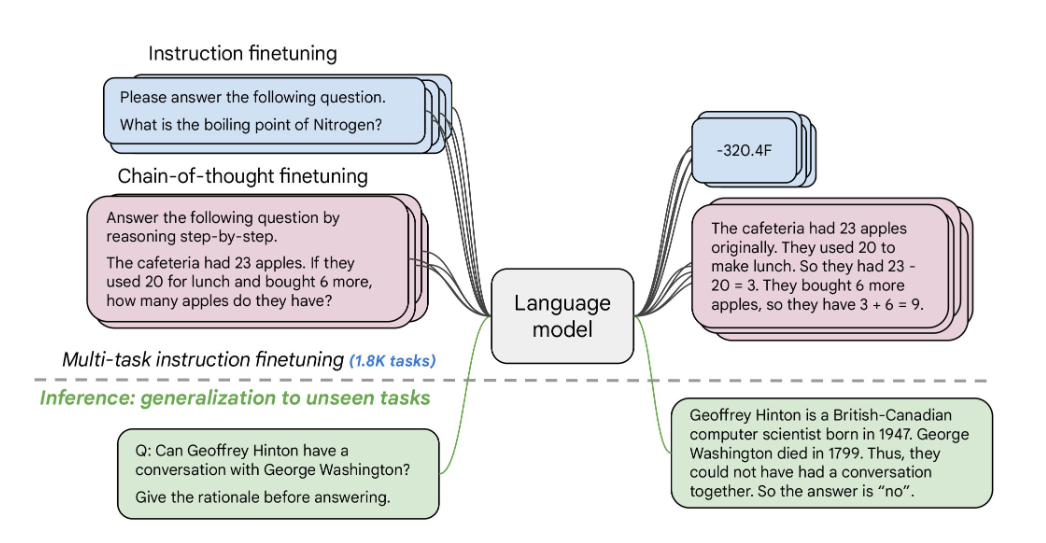

### What is a `open book question`?


You can imagine an `open book` question similar to an examen where you are allowed to bring in text documents or cheat sheets that help you answer questions in an examen. Kinda like bringing a history book to an history examen.

In `T5's` terms, this means the model is given a `question` and an **additional piece of textual information** or so called `context`.

This enables the `T5` model to answer questions on textual datasets like `medical records`,`newsarticles` , `wiki-databases` , `stories` and `movie scripts` , `product descriptions`, 'legal documents' and many more.

### What is a `closed book question`?

A `closed book question` is the exact opposite of a `open book question`. In an examen scenario, you are only allowed to use what you have memorized in your brain and nothing else.      
In `T5's` terms this means that T5 can only use it's stored weights to answer a `question` and is given **no aditional context**.        
`T5` was pre-trained on the [C4 dataset](https://commoncrawl.org/) which contains **petabytes  of web crawling data**  collected over the last 8 years, including Wikipedia in every language.

In [ ]:
documentAssembler = nlp.DocumentAssembler().setInputCol("text").setOutputCol("document")

llm = (
    nlp.T5Transformer.pretrained("t5_base", "en")
    .setInputCols("document")
    .setOutputCol("answers")
    .setTask("question: ")
)

pipeline = nlp.Pipeline(stages=[documentAssembler, llm])

t5_base download started this may take some time.
Approximate size to download 451.8 MB
[OK!]


### Answer **Closed Book Questions**  
Closed book means that no additional context is given and the model must answer the question with the knowledge stored in it's weights.

*T5 models were released in 2019 and Flan T5 ones in 2022, so recent information is outdated in their internal knowledge.*

In [ ]:
# define Data

# For closed book question we don't need to add the keyword for questions (defined with `.setTask`)
data = [
    ["Who is president of the US? "],
    ["What is the most common language in Peru?"],
    ["What is the capital of Germany? "],
]
df = spark.createDataFrame(data).toDF("text")

# Predict on text data with T5

model = pipeline.fit(df)
annotated_df = model.transform(df)
annotated_df.select(["text", "answers.result"]).show(truncate=False)

+-----------------------------------------+--------------+
|text                                     |result        |
+-----------------------------------------+--------------+
|Who is president of the US?              |[Donald Trump]|
|What is the most common language in Peru?|[Spanish]     |
|What is the capital of Germany?          |[Berlin]      |
+-----------------------------------------+--------------+



### Answer **Open Book Questions**
These are questions where we give the model some additional context, that is used to answer the question.

*This approach limits hallucinations as the models need to use the given context to answer the questions, similar to the RAG approach that searches for relevant context in a vector store.*

In [ ]:
context = """Spark NLP is a state-of-the-art Natural Language Processing library built on top of Apache Spark.
It provides simple, performant & accurate NLP annotations for machine learning pipelines that scale easily in a distributed environment.
Spark NLP comes with 36000+ pretrained pipelines and models in more than 200+ languages.
"""

# Add the keyword `context: `(T5 approach)
context = f"context: {context}"

# For open book questions, we need to add the keyword for questions too.
question1 = "What is Spark NLP? "
question2 = "How many languages are supported in Spark NLP? "
question3 = "Can I use Spark NLP to scale my NLP application? "

data = [
    [question1, f"question: {question1}" + context],
    [question2, f"question: {question2}" + context],
    [question3, f"question: {question3}" + context],
]


df = spark.createDataFrame(data, ["question", "text"]).toDF("question", "text")

# Predict on text data with T5

model = pipeline.fit(df)
annotated_df = model.transform(df)
print(context)
annotated_df.select(["question", "answers.result"]).show(truncate=False)

context: Spark NLP is a state-of-the-art Natural Language Processing library built on top of Apache Spark.
It provides simple, performant & accurate NLP annotations for machine learning pipelines that scale easily in a distributed environment.
Spark NLP comes with 36000+ pretrained pipelines and models in more than 200+ languages.

+-------------------------------------------------+-------------------------------------+
|question                                         |result                               |
+-------------------------------------------------+-------------------------------------+
|What is Spark NLP?                               |[Natural Language Processing library]|
|How many languages are supported in Spark NLP?   |[200+]                               |
|Can I use Spark NLP to scale my NLP application? |[easily in a distributed environment]|
+-------------------------------------------------+-------------------------------------+



## Healthcare LLM

At John Snow Labs we are specialists to solve real-world problems with technology. Our specialized, domain-specific, Healthcare LLM can support important tasks in clinical analysis.

We provide:

**Smaller models for specific tasks**
- MedicalBertForSequenceClassification
- MedicalBertForTokenClassifier
- MedicalDistilBertForSequenceClassification
- MedicalSummarizer
- MedicalTextGenerator
- Text2SQL

**Quantized LLM (GGUF)**
- JSL_MedSNer_ZS
- JSL_MedM
- JSL_MedS


To use them, simply contruct a pipeline with `DocumentAssembler` and the desired model annotator. For more examples, check the [Workshop Repository](https://github.com/JohnSnowLabs/spark-nlp-workshop/tree/master/healthcare-nlp).


### Clinical Text Summarization

In [ ]:
document_assembler = (
    nlp.DocumentAssembler().setInputCol("text").setOutputCol("document")
)

summarizer = (
    medical.Summarizer.pretrained("summarizer_clinical_jsl", "en", "clinical/models")
    .setInputCols(["document"])
    .setOutputCol("summary")
    .setMaxTextLength(512)
    .setMaxNewTokens(512)
)


pipeline = nlp.Pipeline(stages=[document_assembler, summarizer])

model = pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))


summarizer_clinical_jsl download started this may take some time.
[OK!]


In [ ]:
text = """ Patient with hypertension, syncope, and spinal stenosis - for recheck.
 (Medical Transcription Sample Report)
 SUBJECTIVE:
 The patient is a 78-year-old female who returns for recheck. She has hypertension. She denies difficulty with chest pain, palpations, orthopnea, nocturnal dyspnea, or edema.
 PAST MEDICAL HISTORY / SURGERY / HOSPITALIZATIONS:
 Reviewed and unchanged from the dictation on 12/03/2003.
 MEDICATIONS:
 Atenolol 50 mg daily, Premarin 0.625 mg daily, calcium with vitamin D two to three pills daily, multivitamin daily, aspirin as needed, and TriViFlor 25 mg two pills daily. She also has Elocon cream 0.1% and Synalar cream 0.01% that she uses as needed for rash.
 """


data = spark.createDataFrame([[text]]).toDF("text")

In [ ]:
result = model.transform(data)
result.select("summary.result").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|result                                                                                                                                                                                                                                                |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[A 78-year-old female with hypertension, syncope, and spinal stenosis returns for recheck. She denies chest pain, palpations, orthopnea, nocturnal dyspnea, or edema. She is on multiple medications and has Elocon cream and Synalar cream for rash.]|
+---

### Clinical LLM

Import the model with the `LLMLoader` annotator.

In [ ]:
# 3.7GB
jsl_meds_llm = medical.LLMLoader(spark).pretrained(
    "jsl_meds_q8_v1", "en", "clinical/models"
)

In [ ]:
prompt = """
Based on the following text, what age group is most susceptible to breast cancer?

## Text:
The exact cause of breast cancer is unknown. However, several risk factors can increase your likelihood of developing breast cancer, such as:
- A personal or family history of breast cancer
- A genetic mutation, such as BRCA1 or BRCA2
- Exposure to radiation
- Age (most commonly occurring in women over 50)
- Early onset of menstruation or late menopause
- Obesity
- Hormonal factors, such as taking hormone replacement therapy
"""

response = jsl_meds_llm.generate(prompt)
response

' The age group most susceptible to breast cancer, as mentioned in the text, is women over the age of 50.'

## **Retrieval Augmented Generation with Spark NLP**

### RAG Architecture
A typical RAG application has two main components:

**Indexing**: a pipeline for ingesting data from a source and indexing it. This usually happens offline.
- `Load`: First we need to load our data. This is done with DocumentLoaders.
- `Split`: Text splitters break large Documents into smaller chunks. This is useful both for indexing data and for passing it in to a model, since large chunks are harder to search over and won’t fit in a model’s finite context window.
- `Store`: We need somewhere to store and index our splits, so that they can later be searched over. This is often done using a VectorStore and Embeddings model.

**Retrieval and generation**: the actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.
[source](https://python.langchain.com/docs/use_cases/question_answering/)


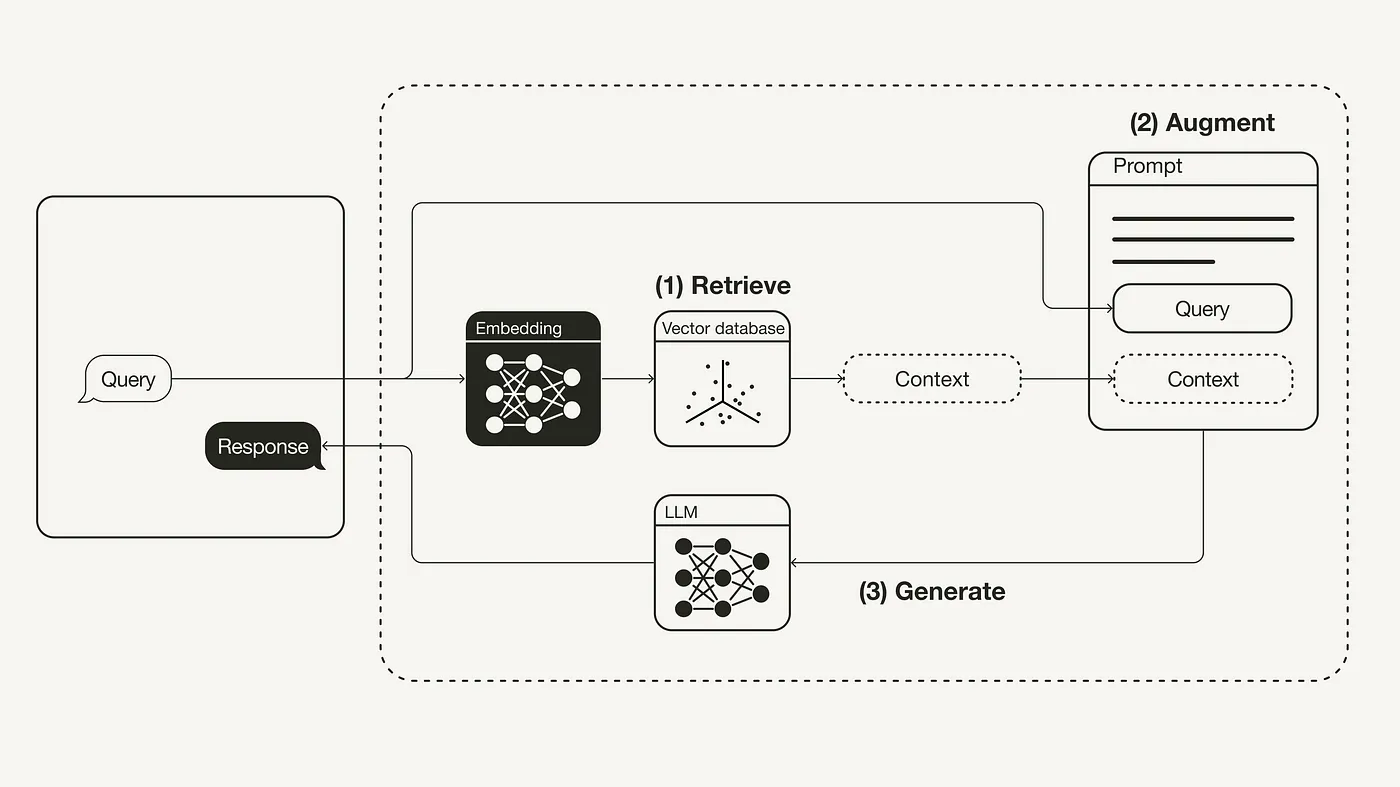

[image source](https://towardsdatascience.com/retrieval-augmented-generation-rag-from-theory-to-langchain-implementation-4e9bd5f6a4f2)

### Dataset

In [6]:
! wget -q https://github.com/JohnSnowLabs/spark-nlp-workshop/raw/master/healthcare-nlp/data/diabetes_txt_files.zip

In [7]:
import shutil

filename = "./diabetes_txt_files.zip"
extract_dir = "./"
archive_format = "zip"

shutil.unpack_archive(filename, extract_dir, archive_format)

In [8]:
multi_doc = spark.read.text("./diabetes_txt_files", wholetext=True).toDF("text")
multi_doc = (
    multi_doc.withColumn("filename", F.input_file_name())
    .withColumn("filename", F.split("filename", "/"))
    .withColumn("filename", F.col("filename")[F.size("filename") - 1])
)
multi_doc.show(10, truncate=100)

print("document count:", multi_doc.count())

+----------------------------------------------------------------------------------------------------+-----------------------+
|                                                                                                text|               filename|
+----------------------------------------------------------------------------------------------------+-----------------------+
|Diabetes mellitus is a group of diseases associated with various metabolic disorders, the main fe...|PMC4020724_abstract.txt|
|Objective: The peer interaction–based online model has been influential in the recent development...|PMC7432193_abstract.txt|
|Gestational diabetes mellitus (GDM) is associated with developing type 2 diabetes, but very few s...|PMC5770032_abstract.txt|
|A diagnosis of diabetes or hyperglycemia should be confirmed prior to ordering, dispensing, or ad...|PMC6104264_abstract.txt|
|The aim of this study was to describe the characteristics and outcomes of pregnancies in a nation...|PMC705437

### Document Splitting


In [9]:
def DocumentSplitter(spark_df, input_col="text", chunk_size=100, chunk_overlap=10):
    from sparknlp.annotator import (
        DocumentAssembler,
        DocumentCharacterTextSplitter,
    )
    from pyspark.ml import Pipeline

    document_assembler = (
        DocumentAssembler().setInputCol(input_col).setOutputCol("document")
    )

    character_text_splitter = (
        DocumentCharacterTextSplitter()
        .setInputCols(["document"])
        .setOutputCol("splits")
        .setChunkSize(chunk_size)
        .setChunkOverlap(chunk_overlap)
        .setExplodeSplits(True)
        .setSplitPatterns(["\n\n", "\n", " "])
    )

    pipeline = Pipeline().setStages([document_assembler, character_text_splitter])

    result_df = pipeline.fit(spark_df).transform(spark_df)

    splitted_pd_df = result_df.selectExpr(
        "splits.result[0] as splits",
        "splits.metadata[0].document as splits_id",
        "filename as document_id",
    ).toPandas()

    return splitted_pd_df

In [10]:
splitted_pd_df = DocumentSplitter(
    multi_doc.limit(100), chunk_size=1000, chunk_overlap=50
)
splitted_pd_df

,splits,splits_id,document_id
0,Diabetes mellitus is a group of diseases assoc...,0,PMC4020724_abstract.txt
1,A scheme of the relationship between etiology...,1,PMC4020724_abstract.txt
2,The classification of glucose metabolism disor...,2,PMC4020724_abstract.txt
3,on the degree of hyperglycemia occurring as a ...,3,PMC4020724_abstract.txt
4,*Casual plasma glucose ≥200 mg/dL (≥11.1 mmol/...,4,PMC4020724_abstract.txt
...,...,...,...
386,"In 1992, 1,091 individuals were interviewed an...",1,PMC6944834_abstract.txt
387,These results suggest that particular efforts ...,2,PMC6944834_abstract.txt
388,To systematically review the risk factors for ...,0,PMC7779280_abstract.txt
389,A total of 24 case–control studies were includ...,1,PMC7779280_abstract.txt


In [11]:
def LoadDocument(splitted_pd_df, page_content_column="splits"):
    from langchain.document_loaders import DataFrameLoader

    loader = DataFrameLoader(splitted_pd_df, page_content_column)
    splitted_docs = loader.load()

    return splitted_docs

In [12]:
splitted_docs = LoadDocument(splitted_pd_df, page_content_column="splits")
splitted_docs[:5]

[Document(metadata={'splits_id': '0', 'document_id': 'PMC4020724_abstract.txt'}, page_content='Diabetes mellitus is a group of diseases associated with various metabolic disorders, the main feature of which is chronic hyperglycemia due to insufficient insulin action. Its pathogenesis involves both genetic and environmental factors. The long‐term persistence of metabolic disorders can cause susceptibility to specific complications and also foster arteriosclerosis. Diabetes mellitus is associated with a broad range of clinical presentations, from being asymptomatic to ketoacidosis or coma, depending on the degree of metabolic disorder.\nNote: Those that cannot at present be classified as any of the above are called unclassifiable.\nThe occurrence of diabetes‐specific complications has not been confirmed in some of these conditions.\nThe occurrence of diabetes‐specific complications has not been confirmed in some of these conditions.'),
 Document(metadata={'splits_id': '1', 'document_id':

### JohnSnowLabsLangChainEmbedder

We use our Embedding model integrated to LangChain ecosystem. The syntax is the same as the [NLU](https://github.com/JohnSnowLabs/nlu) library.

For more details, check the documenation [here](https://nlp.johnsnowlabs.com/docs/en/jsl/install).

In [13]:
from johnsnowlabs.llm import embedding_retrieval

embeddings = embedding_retrieval.JohnSnowLabsLangChainEmbedder(
    "en.embed_sentence.instructor_base", hardware_target=hardware
)

Spark Session already created, some configs may not take.
👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_8734.json
instructor_base download started this may take some time.
Approximate size to download 387.7 MB
[OK!]


In [14]:
embeddings.embed_query("I can use Spark NLP models in LangChain")

[-0.01572931557893753,
 -0.025807099416851997,
 0.03702715411782265,
 0.01700609177350998,
 0.01924830861389637,
 -0.058638688176870346,
 -0.06061050668358803,
 0.051447782665491104,
 0.01317853294312954,
 -0.043272633105516434,
 0.027849797159433365,
 -0.04335855692625046,
 0.06744261831045151,
 0.03792579099535942,
 0.06656619161367416,
 0.03323127701878548,
 0.022519830614328384,
 0.018806835636496544,
 -0.0015986576909199357,
 0.03245837986469269,
 0.02486085705459118,
 -0.039530180394649506,
 -0.051604051142930984,
 0.059798311442136765,
 -0.022894617170095444,
 0.038251932710409164,
 0.03750705346465111,
 -0.017199408262968063,
 0.0006977148586884141,
 0.00659424951300025,
 0.07872387766838074,
 -0.030460484325885773,
 -0.037412527948617935,
 0.06388857215642929,
 -0.049121834337711334,
 -0.007049481850117445,
 -0.032045550644397736,
 -0.034921009093523026,
 -0.020054280757904053,
 0.029711196199059486,
 0.02024977281689644,
 -0.04517889395356178,
 -0.03386010602116585,
 0.060730

### Vector Databases

In [15]:
%%time
from langchain.vectorstores import FAISS

db = FAISS.from_documents(splitted_docs, embeddings)
faiss_retriever = db.as_retriever(search_kwargs={"k": 3})

CPU times: user 1.18 s, sys: 173 ms, total: 1.36 s
Wall time: 2min 57s


In [16]:
relevavant_docs = faiss_retriever.get_relevant_documents("causes of diabetes")
len(relevavant_docs)

3

In [17]:
relevavant_docs

[Document(metadata={'splits_id': '0', 'document_id': 'PMC6198430_abstract.txt'}, page_content='Diabetic patients, during the course of the disease, are most likely to experience depressive symptoms that might ultimately lead to suicidal ideation or suicide. The size of literature in diabetes depression/suicide is a good indicator of national and international efforts to address psychological co-morbidities associated with diabetes mellitus (DM). Therefore, the objective of this study was to give a comprehensive analysis, both quantitative and qualitative, of scientific literature in diabetes depression/suicide.\nSciVerse Scopus was used to retrieve relevant literature up to 2016.'),
 Document(metadata={'splits_id': '0', 'document_id': 'PMC6882272_abstract.txt'}, page_content='Background: Diabetes mellitus (DM) is a common chronic disorder in children and is caused by absolute or relative insulin deficiency, with or without insulin resistance. There are several different forms of childh

### OpenAI For Text Generation

In [18]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
import textwrap


# completion llm

llm = ChatOpenAI(
    openai_api_key=OPENAI_API_KEY,
    model_name="gpt-3.5-turbo-16k",
    temperature=0.0,
)

In [19]:
prompt = """
Use the following pieces of context to answer the user's question. If you return an answer, end with 'It's my pleasure'.
If you don't know the answer, just say that you don't know, don't try to make up an answer .

Context: {context}
Question: {question}
Helpful Answer:"""

QA_CHAIN_PROMPT = PromptTemplate.from_template(prompt)

In [20]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=faiss_retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT},
)

question = "causes for diabetes?"
result = qa_chain({"query": question})

textwrap.wrap(result["result"])

['The causes of diabetes can vary depending on the type of diabetes.',
 'Type 1 diabetes is believed to be caused by an autoimmune reaction',
 "where the body's immune system mistakenly attacks and destroys the",
 'insulin-producing cells in the pancreas. The exact cause of type 2',
 'diabetes is not fully understood, but it is thought to involve a',
 'combination of genetic factors and lifestyle factors such as obesity,',
 "lack of physical activity, and unhealthy diet. It's my pleasure to",
 'help!']

In [21]:
pd.DataFrame([doc.metadata for doc in result["source_documents"]])

,splits_id,document_id
0,0,PMC6198430_abstract.txt
1,0,PMC6882272_abstract.txt
2,0,PMC7054376_abstract.txt
